# Graph Neural Network Training Pipeline

Multi-Dataset Graph Classification with Noise-Robust Training

## 1. Setup and Dependencies

In [1]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.3 MB/s eta 0:00:00a 0:00:01


In [2]:
import os
import gc
import sys
import torch
import pandas as pd
import matplotlib.pyplot as plt
import logging
from tqdm import tqdm
from torch_geometric.loader import DataLoader
from torch.utils.data import random_split
import argparse
from sklearn.metrics import f1_score

In [3]:
helper_scripts_path = '/kaggle/input/d/leonardosandri/myhackatonhelperscripts/'

if os.path.exists(helper_scripts_path):
    # Add this path to the beginning of Python's search list
    sys.path.insert(0, helper_scripts_path)
    print(f"Successfully added '{helper_scripts_path}' to sys.path.")
    print(f"Contents of '{helper_scripts_path}': {os.listdir(helper_scripts_path)}") # Verify
else:
    print(f"WARNING: Helper scripts path not found: {helper_scripts_path}")
    print("Please ensure 'myhackathonhelperscripts' dataset is correctly added to the notebook.")

# Start import of utils modules
try:
    from preprocessor import MultiDatasetLoader
    from utils import set_seed
    # from conv import GINConv as OriginalRepoGINConv
    from models_EDandBatch_norm import GNN
    print("Successfully imported modules.")
except ImportError as e:
    print(f"ERROR importing module: {e}")
    print("Please check that the .py files exist directly under the helper_scripts_path and have no syntax errors.")
    # print("Current sys.path:", sys.path)

# Set the random seed
set_seed() # seed 777 default

Successfully added '/kaggle/input/d/leonardosandri/myhackatonhelperscripts/' to sys.path.
Contents of '/kaggle/input/d/leonardosandri/myhackatonhelperscripts/': ['models_edge_drop.py', 'zipthefolder.py', 'loadData.py', 'utils.py', 'models_layer_drop.py', 'models_EDandBatch_norm.py', 'models.py', 'conv.py', 'preprocessor.py', '__init__.py']
Successfully imported modules.


## 2. Data Preprocessing Functions


In [4]:
def add_zeros(data):
    data.x = torch.zeros(data.num_nodes, dtype=torch.long)
    return data

## 3. Training and Evaluation Functions

In [5]:
def train(data_loader, model, optimizer, criterion, device, save_checkpoints, checkpoint_path, current_epoch, scheduler=None, args=None):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for batch_idx, data in enumerate(tqdm(data_loader, desc="Iterating training graphs", unit="batch")):
        data = data.to(device)
        optimizer.zero_grad()
        
        try:
            output = model(data)
        except IndexError as e:
            print(f"Error in batch with {data.num_nodes} nodes, edge_max={data.edge_index.max()}")
            print(f"Batch info: x.shape={data.x.shape}, edge_index.shape={data.edge_index.shape}")
            raise e
            
        loss = criterion(output, data.y)
        loss.backward()

        # Numerical stability addition
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        # Step OneCycleLR scheduler after each batch
        if scheduler is not None and args.scheduler_type == 'OneCycleLR':
            scheduler.step()
            
        total_loss += loss.item()
        pred = output.argmax(dim=1)
        correct += (pred == data.y).sum().item()
        total += data.y.size(0)

    # Save checkpoints if required
    if save_checkpoints:
        checkpoint_file = f"{checkpoint_path}_epoch_{current_epoch + 1}.pth"
        torch.save(model.state_dict(), checkpoint_file)
        print(f"Checkpoint saved at {checkpoint_file}")

    return total_loss / len(data_loader),  correct / total

In [6]:
# CELL 7 (Corrected)
def evaluate(data_loader, model, criterion, device, calculate_accuracy=False): # Added 'criterion' argument
    model.eval()
    correct = 0
    total = 0
    predictions = []
    true_labels = []
    total_loss = 0

    with torch.no_grad():
        for data in tqdm(data_loader, desc="Iterating eval graphs", unit="batch"):
            data = data.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            predictions.extend(pred.cpu().numpy())
            

            if calculate_accuracy:
                correct += (pred == data.y).sum().item()
                total += data.y.size(0)
                total_loss += criterion(output, data.y).item()
                true_labels.extend(data.y.cpu().numpy())
                
    if calculate_accuracy:
        print(f"Debug: predictions={len(predictions)}, true_labels={len(true_labels)}")  # Add this
        accuracy = correct / total
        # Calculate F1 scores
        f1_macro = f1_score(true_labels, predictions, average='macro')        
        return  total_loss / len(data_loader), accuracy, f1_macro
    return predictions

## 4. Utility Functions

In [7]:
def save_predictions(predictions, test_path):
    script_dir = os.getcwd() 
    submission_folder = os.path.join(script_dir, "submission")
    test_dir_name = os.path.basename(os.path.dirname(test_path))
    
    os.makedirs(submission_folder, exist_ok=True)
    
    output_csv_path = os.path.join(submission_folder, f"testset_{test_dir_name}.csv")
    
    test_graph_ids = list(range(len(predictions)))
    output_df = pd.DataFrame({
        "id": test_graph_ids,
        "pred": predictions
    })
    
    output_df.to_csv(output_csv_path, index=False)
    print(f"Predictions saved to {output_csv_path}")

In [8]:
def plot_training_progress(train_losses, train_accuracies, val_losses, val_accuracies, output_dir):
    """
    Plot training and validation progress over epochs.
    
    Args:
        train_losses: List of training losses per epoch
        train_accuracies: List of training accuracies per epoch  
        val_losses: List of validation losses per epoch
        val_accuracies: List of validation accuracies per epoch
        output_dir: Directory to save the plot
    """
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(15, 6))
    
    # Plot losses
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Training Loss", color='blue', marker='o')
    plt.plot(epochs, val_losses, label="Validation Loss", color='red', marker='s')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss per Epoch')
    plt.legend()
    plt.grid(True)
    
    # Plot accuracies
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label="Training Accuracy", color='green', marker='o')
    plt.plot(epochs, val_accuracies, label="Validation Accuracy", color='orange', marker='s')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy per Epoch')
    plt.legend()
    plt.grid(True)
    
    # Save plot
    os.makedirs(output_dir, exist_ok=True)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "training_progress.png"))
    plt.show()
    plt.close()

## 5. Configuration and Arguments

In [9]:
def get_user_input(prompt, default=None, required=False, type_cast=str):

    while True:
        user_input = input(f"{prompt} [{default}]: ")
        
        if user_input == "" and required:
            print("This field is required. Please enter a value.")
            continue
        
        if user_input == "" and default is not None:
            return default
        
        if user_input == "" and not required:
            return None
        
        try:
            return type_cast(user_input)
        except ValueError:
            print(f"Invalid input. Please enter a valid {type_cast.__name__}.")

In [10]:
def get_arguments():
    """Set training configuration directly"""
    args = {
        # Dataset selection
        'dataset': 'B',  # Choose: A, B, C, D
        'train_mode': 1,  # 1=single dataset, 2=all datasets
        
        # Model config
        #'gnn': 'gin',  # gin, gin-virtual, gcn, gcn-virtual
        'num_layer': 2,
        'emb_dim': 128,
        'drop_ratio': 0.3,   # Dropout ratio
        'virtual_node': True, # True to use virtual node, False otherwise
        'residual': True,    # True to use residual connections, False otherwise
        'JK': "last",         # Jumping Knowledge: "last", "sum", "cat"
        'edge_drop_ratio' : 0.15,
        'batch_norm' : True,
        'graph_pooling': "mean", # "sum", "mean", "max", "attention", "set2set"
        
        # Training config
        'batch_size': 64,
        'epochs': 200,
        'baseline_mode': 3,  # 1=CE, 2=Noisy CE, 3 GCE
        'noise_prob': 0.2,
        'gce_q' : 0.9,
        'initial_lr' : 5e-3,

        # Best model criteria
        'best_model_criteria': 'f1',  # 'accuracy' or 'f1'

        # Lr scheduler config =================================================================================================================
        'use_scheduler' : True,
        'scheduler_type': 'ReduceLROnPlateau',  # Options: 'StepLR', 'ReduceLROnPlateau', 'CosineAnnealingLR', 'ExponentialLR', 'OneCycleLR'

        # StepLR parameters
        'step_size': 30,      # Period of learning rate decay for StepLR
        'gamma': 0.5,         # Multiplicative factor of learning rate decay
        
        # ReduceLROnPlateau parameters
        'patience_lr': 12,    # Number of epochs with no improvement after which LR will be reduced
        'factor': 0.5,        # Factor by which the learning rate will be reduced
        'min_lr': 1e-7,       # Lower bound on the learning rate
        
        # CosineAnnealingLR parameters
        'T_max': 50,          # Maximum number of iterations for cosine annealing
        'eta_min': 1e-6,      # Minimum learning rate
        
        # ExponentialLR parameters
        'gamma_exp': 0.95,    # Multiplicative factor of learning rate decay for ExponentialLR
        
        # OneCycleLR parameters
        'max_lr': 1e-3,       # Upper learning rate boundary
        'pct_start': 0.3,     # Percentage of cycle spent increasing learning rate

        # =====================================================================================================================================
        
        # Early stopping config
        'early_stopping': True,  # Enable/disable early stopping
        'patience': 25,          # Number of epochs to wait without improvement
        
        # System config
        'device': 0,
        'num_checkpoints': 1,    # 1 for saving every 10 epochs, 0 for saving every epoch
    }
    return argparse.Namespace(**args)

In [11]:
def populate_args(args):
    print("Arguments received:")
    for key, value in vars(args).items():
        print(f"{key}: {value}")
args = get_arguments()
populate_args(args)

Arguments received:
dataset: B
train_mode: 1
num_layer: 2
emb_dim: 128
drop_ratio: 0.3
virtual_node: True
residual: True
JK: last
edge_drop_ratio: 0.15
batch_norm: True
graph_pooling: mean
batch_size: 64
epochs: 200
baseline_mode: 3
noise_prob: 0.2
gce_q: 0.9
initial_lr: 0.005
best_model_criteria: f1
use_scheduler: True
scheduler_type: ReduceLROnPlateau
step_size: 30
gamma: 0.5
patience_lr: 12
factor: 0.5
min_lr: 1e-07
T_max: 50
eta_min: 1e-06
gamma_exp: 0.95
max_lr: 0.001
pct_start: 0.3
early_stopping: True
patience: 25
device: 0
num_checkpoints: 1


## 6. Loss Function Definition

In [12]:
class NoisyCrossEntropyLoss(torch.nn.Module):
    def __init__(self, p_noisy):
        super().__init__()
        self.p = p_noisy
        self.ce = torch.nn.CrossEntropyLoss(reduction='none')

    def forward(self, logits, targets):
        losses = self.ce(logits, targets)
        weights = (1 - self.p) + self.p * (1 - torch.nn.functional.one_hot(targets, num_classes=logits.size(1)).float().sum(dim=1))
        return (losses * weights).mean()

In [13]:
# CELL 12.1 (New Cell or append to existing cell 12)
class GeneralizedCrossEntropyLoss(torch.nn.Module):
    def __init__(self, q=0.7):
        """
        Generalized Cross Entropy Loss.
        q is a hyperparameter, 0 < q <= 1.
        As q -> 0, GCE approaches standard CE.
        """
        super(GeneralizedCrossEntropyLoss, self).__init__()
        if not (0 < q <= 1):
            # While the limit q->0 is CE, for q=0 direct computation is 1/0.
            # The paper usually uses q > 0.
            raise ValueError("q should be in (0, 1]")
        self.q = q

    def forward(self, logits, targets):
        probs = torch.softmax(logits, dim=1)
        # Select probabilities of the target class for each sample
        target_probs = probs[torch.arange(targets.size(0)), targets]

        # To prevent issues with target_probs being exactly 0,
        # especially if q is very small (though here q > 0).
        # However, 0^q is 0 for q > 0, so it should be fine.
        # For extra safety: target_probs = target_probs.clamp(min=1e-8)

        # Add numerical stability
        target_probs = target_probs.clamp(min=1e-7, max=1-1e-7)

        # GCE loss: (1 - p_t^q) / q
        loss = (1 - (target_probs ** self.q)) / self.q
        return loss.mean()

## 7. Model creation

### 7.1 Config section


In [14]:
print("=" * 60)
print("Enhanced GNN Training Pipeline")
print("=" * 60)

# Get configuration
args = get_arguments()

print("\nConfiguration:")
for key, value in vars(args).items():
    print(f"  {key}: {value}")

# Setup device
device = torch.device(f"cuda:{args.device}" if torch.cuda.is_available() else "cpu")
print(f"\nUsing device: {device}")

Enhanced GNN Training Pipeline

Configuration:
  dataset: B
  train_mode: 1
  num_layer: 2
  emb_dim: 128
  drop_ratio: 0.3
  virtual_node: True
  residual: True
  JK: last
  edge_drop_ratio: 0.15
  batch_norm: True
  graph_pooling: mean
  batch_size: 64
  epochs: 200
  baseline_mode: 3
  noise_prob: 0.2
  gce_q: 0.9
  initial_lr: 0.005
  best_model_criteria: f1
  use_scheduler: True
  scheduler_type: ReduceLROnPlateau
  step_size: 30
  gamma: 0.5
  patience_lr: 12
  factor: 0.5
  min_lr: 1e-07
  T_max: 50
  eta_min: 1e-06
  gamma_exp: 0.95
  max_lr: 0.001
  pct_start: 0.3
  early_stopping: True
  patience: 25
  device: 0
  num_checkpoints: 1

Using device: cuda:0


### 7.2 Data Loading

In [15]:
print("\n" + "="*40)
print("LOADING DATA")
print("="*40)

base_path = '/kaggle/input/deep-dataset-preprocessed/processed_data_separate'

# Prepare training/validation data based on mode
if args.train_mode == 1:
    # Single dataset mode
    dataset_name = args.dataset
    train_dataset = torch.load(f'{base_path}/{dataset_name}_train_graphs.pt', weights_only=False)
    train_dataset = [add_zeros(data) for data in train_dataset]
    
    val_dataset = torch.load(f'{base_path}/{dataset_name}_val_graphs.pt', weights_only=False)
    val_dataset = [add_zeros(data) for data in val_dataset]
    
    test_dataset = torch.load(f'{base_path}/{dataset_name}_test_graphs.pt', weights_only=False)
    test_dataset = [add_zeros(data) for data in test_dataset]
    print(f"Using single dataset: {dataset_name}")
else:
    # All datasets mode
    train_dataset = []
    val_dataset = []
    test_dataset = torch.load(f'{base_path}/{args.dataset}_test_graphs.pt', weights_only=False)  # Test on specified dataset
    
    for ds_name in ['A', 'B', 'C', 'D']:
        train_dataset.extend(torch.load(f'{base_path}/{ds_name}_train_graphs.pt', weights_only=False))
        val_dataset.extend(torch.load(f'{base_path}/{ds_name}_val_graphs.pt', weights_only=False))
    
    print("Using all datasets for training")

print(f"Train samples: {len(train_dataset)}")
print(f"Val samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=args.batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False, num_workers=0)


LOADING DATA
Using single dataset: B
Train samples: 5040
Val samples: 560
Test samples: 1560


### 7.3 Model Setup

In [16]:

print("\n" + "="*40)
print("MODEL SETUP")
print("="*40)

# Initialize model
model = GNN(num_class=6, # Assuming 6 classes based on original notebook
            num_layer=args.num_layer,
            emb_dim=args.emb_dim,
            drop_ratio=args.drop_ratio,
            virtual_node=args.virtual_node,
            residual=args.residual,
            JK=args.JK,
            graph_pooling=args.graph_pooling,
            edge_drop_ratio = args.edge_drop_ratio,
            batch_norm=args.batch_norm
           )

model = model.to(device)

# Setup optimizer and loss
optimizer = torch.optim.Adam(model.parameters(), lr=args.initial_lr)

if args.baseline_mode == 2:
    criterion = NoisyCrossEntropyLoss(args.noise_prob)
    print(f"Using Noisy Cross Entropy Loss (p={args.noise_prob})")
elif args.baseline_mode == 3: # <--- ADD THIS BLOCK FOR GCE
    criterion = GeneralizedCrossEntropyLoss(q=args.gce_q)
    print(f"Using Generalized Cross Entropy (GCE) Loss (q={args.gce_q})")
else:
    criterion = torch.nn.CrossEntropyLoss()
    print("Using standard Cross Entropy Loss")

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

# Setup logging and checkpoints
exp_name = f"gin_dataset{args.dataset}_mode{args.train_mode}"
logs_dir = os.path.join("logs", exp_name)
checkpoints_dir = os.path.join("checkpoints", exp_name)
os.makedirs(logs_dir, exist_ok=True)
os.makedirs(checkpoints_dir, exist_ok=True)

# Setup logging
log_file = os.path.join(logs_dir, "training.log")
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(message)s',
    handlers=[
        logging.FileHandler(log_file),
        logging.StreamHandler()
    ]
)

#best_model_path = os.path.join(checkpoints_dir, "best_model.pth")
best_model_path = '/kaggle/working/best_model.pth'


MODEL SETUP
Using Generalized Cross Entropy (GCE) Loss (q=0.9)
Model parameters: 203,400


## 8. Main training loop

### 8.1 Learning rate settings

In [17]:
# Learning Rate Scheduler Setup
print("\n" + "="*40)
print("SCHEDULER SETUP")
print("="*40)

# Update optimizer with initial learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=args.initial_lr)

scheduler = None
if args.use_scheduler:
    if args.scheduler_type == 'StepLR':
        scheduler = torch.optim.lr_scheduler.StepLR(
            optimizer, 
            step_size=args.step_size, 
            gamma=args.gamma
        )
        print(f"Using StepLR scheduler: step_size={args.step_size}, gamma={args.gamma}")
        
    elif args.scheduler_type == 'ReduceLROnPlateau':
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, 
            mode='min',  # We want to reduce LR when validation loss stops decreasing
            factor=args.factor,
            patience=args.patience_lr,
            min_lr=args.min_lr,
        )
        print(f"Using ReduceLROnPlateau scheduler: factor={args.factor}, patience={args.patience_lr}, min_lr={args.min_lr}")
        
    elif args.scheduler_type == 'CosineAnnealingLR':
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer,
            T_max=args.T_max,
            eta_min=args.eta_min
        )
        print(f"Using CosineAnnealingLR scheduler: T_max={args.T_max}, eta_min={args.eta_min}")
        
    elif args.scheduler_type == 'ExponentialLR':
        scheduler = torch.optim.lr_scheduler.ExponentialLR(
            optimizer,
            gamma=args.gamma_exp
        )
        print(f"Using ExponentialLR scheduler: gamma={args.gamma_exp}")
        
    elif args.scheduler_type == 'OneCycleLR':
        # Calculate total steps for OneCycleLR
        total_steps = len(train_loader) * args.epochs
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=args.max_lr,
            total_steps=total_steps,
            pct_start=args.pct_start
        )
        print(f"Using OneCycleLR scheduler: max_lr={args.max_lr}, total_steps={total_steps}, pct_start={args.pct_start}")
        
    else:
        print(f"Unknown scheduler type: {args.scheduler_type}. No scheduler will be used.")
        args.use_scheduler = False
else:
    print("No learning rate scheduler will be used.")

print(f"Initial learning rate: {args.initial_lr}")


SCHEDULER SETUP
Using ReduceLROnPlateau scheduler: factor=0.5, patience=12, min_lr=1e-07
Initial learning rate: 0.005


### Training loop Call


In [18]:
print("\n" + "="*40)
print("TRAINING")
print("="*40)

best_val_metric = 0.0
metric_name = args.best_model_criteria.upper()
print(f"Using {metric_name} as best model criteria")

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
learning_rates = []
true_labels = []

# Early stopping variables
if args.early_stopping:
    epochs_without_improvement = 0
    print(f"Early stopping enabled with patience: {args.patience}")
else:
    print("Early stopping disabled")

# Calculate checkpoint intervals
if args.num_checkpoints == 1:
    checkpoint_intervals = [i for i in range(10, args.epochs + 1, 10)]
else:
    checkpoint_intervals = [args.epochs]

for epoch in range(args.epochs):
    print(f"\nEpoch {epoch + 1}/{args.epochs}")
    print("-" * 30)

    # Get current learning rate
    current_lr = optimizer.param_groups[0]['lr']
    learning_rates.append(current_lr)
    
    # Training
    train_loss, train_acc = train(
        train_loader, model, optimizer, criterion, device,
        save_checkpoints=(epoch + 1 in checkpoint_intervals),
        checkpoint_path=os.path.join(checkpoints_dir, f"model_{args.dataset}"),
        current_epoch=epoch,
        scheduler=scheduler,
        args=args
    )
    
    # Validation with F1 scores
    val_loss, val_acc, val_f1 = evaluate(
            val_loader, model, criterion, device, calculate_accuracy=True
    )

    # Select metric based on criteria
    current_metric = val_f1 if args.best_model_criteria == 'f1' else val_acc
    
    # Log results
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    print(f"Learning Rate: {current_lr:.2e}")
    print(f"Val F1: {val_f1:.4f}")
    
    if (epoch + 1) % 10 == 0:
        logging.info(f"Epoch {epoch + 1}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, "
                    f"Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}, LR={current_lr:.2e}, "
                    f"F1={val_f1:.4f}")
    
    # Store metrics
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    # Save best model based on chosen criteria
    if current_metric > best_val_metric:
        best_val_metric = current_metric
        torch.save(model.state_dict(), best_model_path)
        print(f"★ New best {metric_name}! {metric_name}: {current_metric:.4f} "
                f"(Acc: {val_acc:.4f}, F1: {val_f1:.4f})")

        # Reset early stopping counter
        if args.early_stopping:
            epochs_without_improvement = 0

    else:
        # No improvement
        if args.early_stopping:
            epochs_without_improvement += 1
            print(f"No improvement for {epochs_without_improvement} epoch(s)")
            
            # Check if we should stop early
            if epochs_without_improvement >= args.patience:
                print(f"\nEarly stopping triggered! No improvement for {args.patience} epochs.")
                print(f"Best {metric_name}: {best_val_metric:.4f}")
                break

    # Learning rate scheduler step
    if scheduler is not None:
        if args.scheduler_type == 'ReduceLROnPlateau':
            # ReduceLROnPlateau needs the metric to monitor
            scheduler.step(val_loss)
        elif args.scheduler_type == 'OneCycleLR':
            # OneCycleLR steps every batch, not every epoch
            # This is handled in the training function
            pass
        else:
            # Other schedulers step every epoch
            scheduler.step()
        
        # Check if learning rate changed
        new_lr = optimizer.param_groups[0]['lr']
        if new_lr != current_lr:
            print(f"Learning rate changed: {current_lr:.2e} → {new_lr:.2e}")

    print(f"\nBest {metric_name}: {best_val_metric:.4f}")


TRAINING
Using F1 as best model criteria
Early stopping enabled with patience: 25

Epoch 1/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 47.59batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.8025, Train Acc: 0.2863
Val Loss: 0.7458, Val Acc: 0.3321
Learning Rate: 5.00e-03
Val F1: 0.1919
★ New best F1! F1: 0.1919 (Acc: 0.3321, F1: 0.1919)

Best F1: 0.1919

Epoch 2/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 46.94batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.7400, Train Acc: 0.3351
Val Loss: 0.7389, Val Acc: 0.3286
Learning Rate: 5.00e-03
Val F1: 0.1778
No improvement for 1 epoch(s)

Best F1: 0.1919

Epoch 3/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 47.26batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.7044, Train Acc: 0.3671
Val Loss: 0.6758, Val Acc: 0.3946
Learning Rate: 5.00e-03
Val F1: 0.2448
★ New best F1! F1: 0.2448 (Acc: 0.3946, F1: 0.2448)

Best F1: 0.2448

Epoch 4/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 47.56batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.6881, Train Acc: 0.3806
Val Loss: 0.7845, Val Acc: 0.2911
Learning Rate: 5.00e-03
Val F1: 0.1383
No improvement for 1 epoch(s)

Best F1: 0.2448

Epoch 5/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 47.12batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.6789, Train Acc: 0.3885
Val Loss: 0.6777, Val Acc: 0.3964
Learning Rate: 5.00e-03
Val F1: 0.2533
★ New best F1! F1: 0.2533 (Acc: 0.3964, F1: 0.2533)

Best F1: 0.2533

Epoch 6/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 46.94batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.6667, Train Acc: 0.3990
Val Loss: 0.7978, Val Acc: 0.2768
Learning Rate: 5.00e-03
Val F1: 0.1659
No improvement for 1 epoch(s)

Best F1: 0.2533

Epoch 7/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 47.18batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.6419, Train Acc: 0.4250
Val Loss: 0.7226, Val Acc: 0.3482
Learning Rate: 5.00e-03
Val F1: 0.2295
No improvement for 2 epoch(s)

Best F1: 0.2533

Epoch 8/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 47.31batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.6375, Train Acc: 0.4246
Val Loss: 0.7655, Val Acc: 0.3071
Learning Rate: 5.00e-03
Val F1: 0.2089
No improvement for 3 epoch(s)

Best F1: 0.2533

Epoch 9/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 46.89batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.6241, Train Acc: 0.4409
Val Loss: 0.6864, Val Acc: 0.3875
Learning Rate: 5.00e-03
Val F1: 0.2421
No improvement for 4 epoch(s)

Best F1: 0.2533

Epoch 10/200
------------------------------


Iterating training graphs: 100%|██████████| 79/79 [00:02<00:00, 26.77batch/s]


Checkpoint saved at checkpoints/gin_datasetB_mode1/model_B_epoch_10.pth


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 47.02batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.6101, Train Acc: 0.4554
Val Loss: 0.6385, Val Acc: 0.4286
Learning Rate: 5.00e-03
Val F1: 0.3189
★ New best F1! F1: 0.3189 (Acc: 0.4286, F1: 0.3189)

Best F1: 0.3189

Epoch 11/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 47.51batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.5967, Train Acc: 0.4633
Val Loss: 0.7742, Val Acc: 0.2964
Learning Rate: 5.00e-03
Val F1: 0.2202
No improvement for 1 epoch(s)

Best F1: 0.3189

Epoch 12/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 47.03batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.6013, Train Acc: 0.4587
Val Loss: 0.5718, Val Acc: 0.4893
Learning Rate: 5.00e-03
Val F1: 0.4024
★ New best F1! F1: 0.4024 (Acc: 0.4893, F1: 0.4024)

Best F1: 0.4024

Epoch 13/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 46.61batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.5755, Train Acc: 0.4853
Val Loss: 0.6359, Val Acc: 0.4268
Learning Rate: 5.00e-03
Val F1: 0.2939
No improvement for 1 epoch(s)

Best F1: 0.4024

Epoch 14/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 47.43batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.5765, Train Acc: 0.4808
Val Loss: 0.7445, Val Acc: 0.3304
Learning Rate: 5.00e-03
Val F1: 0.1853
No improvement for 2 epoch(s)

Best F1: 0.4024

Epoch 15/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 47.59batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.5682, Train Acc: 0.4903
Val Loss: 0.5622, Val Acc: 0.4982
Learning Rate: 5.00e-03
Val F1: 0.3930
No improvement for 3 epoch(s)

Best F1: 0.4024

Epoch 16/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 47.36batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.5520, Train Acc: 0.5048
Val Loss: 0.5471, Val Acc: 0.5125
Learning Rate: 5.00e-03
Val F1: 0.4069
★ New best F1! F1: 0.4069 (Acc: 0.5125, F1: 0.4069)

Best F1: 0.4069

Epoch 17/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 46.73batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.5521, Train Acc: 0.5050
Val Loss: 0.5735, Val Acc: 0.4964
Learning Rate: 5.00e-03
Val F1: 0.4045
No improvement for 1 epoch(s)

Best F1: 0.4069

Epoch 18/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 46.74batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.5519, Train Acc: 0.5032
Val Loss: 0.5901, Val Acc: 0.4750
Learning Rate: 5.00e-03
Val F1: 0.3739
No improvement for 2 epoch(s)

Best F1: 0.4069

Epoch 19/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 47.20batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.5379, Train Acc: 0.5171
Val Loss: 0.5644, Val Acc: 0.4911
Learning Rate: 5.00e-03
Val F1: 0.3879
No improvement for 3 epoch(s)

Best F1: 0.4069

Epoch 20/200
------------------------------


Iterating training graphs: 100%|██████████| 79/79 [00:02<00:00, 26.70batch/s]


Checkpoint saved at checkpoints/gin_datasetB_mode1/model_B_epoch_20.pth


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 46.57batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.5385, Train Acc: 0.5161
Val Loss: 0.5852, Val Acc: 0.4750
Learning Rate: 5.00e-03
Val F1: 0.3695
No improvement for 4 epoch(s)

Best F1: 0.4069

Epoch 21/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 45.90batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.5342, Train Acc: 0.5206
Val Loss: 0.5875, Val Acc: 0.4732
Learning Rate: 5.00e-03
Val F1: 0.3476
No improvement for 5 epoch(s)

Best F1: 0.4069

Epoch 22/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 47.56batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.5360, Train Acc: 0.5200
Val Loss: 0.5357, Val Acc: 0.5161
Learning Rate: 5.00e-03
Val F1: 0.4002
No improvement for 6 epoch(s)

Best F1: 0.4069

Epoch 23/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 46.16batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.5438, Train Acc: 0.5099
Val Loss: 0.5242, Val Acc: 0.5321
Learning Rate: 5.00e-03
Val F1: 0.4276
★ New best F1! F1: 0.4276 (Acc: 0.5321, F1: 0.4276)

Best F1: 0.4276

Epoch 24/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 47.32batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.5323, Train Acc: 0.5222
Val Loss: 0.5355, Val Acc: 0.5196
Learning Rate: 5.00e-03
Val F1: 0.4104
No improvement for 1 epoch(s)

Best F1: 0.4276

Epoch 25/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 46.66batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.5306, Train Acc: 0.5242
Val Loss: 0.6592, Val Acc: 0.4036
Learning Rate: 5.00e-03
Val F1: 0.2853
No improvement for 2 epoch(s)

Best F1: 0.4276

Epoch 26/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 47.02batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.5327, Train Acc: 0.5220
Val Loss: 0.5237, Val Acc: 0.5321
Learning Rate: 5.00e-03
Val F1: 0.4393
★ New best F1! F1: 0.4393 (Acc: 0.5321, F1: 0.4393)

Best F1: 0.4393

Epoch 27/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 47.49batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.5276, Train Acc: 0.5258
Val Loss: 0.5261, Val Acc: 0.5304
Learning Rate: 5.00e-03
Val F1: 0.4322
No improvement for 1 epoch(s)

Best F1: 0.4393

Epoch 28/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 46.02batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.5259, Train Acc: 0.5280
Val Loss: 0.5685, Val Acc: 0.4929
Learning Rate: 5.00e-03
Val F1: 0.3945
No improvement for 2 epoch(s)

Best F1: 0.4393

Epoch 29/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 46.58batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.5264, Train Acc: 0.5280
Val Loss: 0.5183, Val Acc: 0.5339
Learning Rate: 5.00e-03
Val F1: 0.4317
No improvement for 3 epoch(s)

Best F1: 0.4393

Epoch 30/200
------------------------------


Iterating training graphs: 100%|██████████| 79/79 [00:02<00:00, 26.77batch/s]


Checkpoint saved at checkpoints/gin_datasetB_mode1/model_B_epoch_30.pth


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 47.16batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.5231, Train Acc: 0.5290
Val Loss: 0.5401, Val Acc: 0.5161
Learning Rate: 5.00e-03
Val F1: 0.4055
No improvement for 4 epoch(s)

Best F1: 0.4393

Epoch 31/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 47.01batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.5191, Train Acc: 0.5329
Val Loss: 0.5343, Val Acc: 0.5250
Learning Rate: 5.00e-03
Val F1: 0.4341
No improvement for 5 epoch(s)

Best F1: 0.4393

Epoch 32/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 47.13batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.5177, Train Acc: 0.5353
Val Loss: 0.5773, Val Acc: 0.4768
Learning Rate: 5.00e-03
Val F1: 0.3733
No improvement for 6 epoch(s)

Best F1: 0.4393

Epoch 33/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 47.24batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.5145, Train Acc: 0.5379
Val Loss: 0.5153, Val Acc: 0.5375
Learning Rate: 5.00e-03
Val F1: 0.4310
No improvement for 7 epoch(s)

Best F1: 0.4393

Epoch 34/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 44.18batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.5219, Train Acc: 0.5325
Val Loss: 0.5621, Val Acc: 0.4911
Learning Rate: 5.00e-03
Val F1: 0.3956
No improvement for 8 epoch(s)

Best F1: 0.4393

Epoch 35/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 47.56batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.5229, Train Acc: 0.5294
Val Loss: 0.5186, Val Acc: 0.5339
Learning Rate: 5.00e-03
Val F1: 0.4374
No improvement for 9 epoch(s)

Best F1: 0.4393

Epoch 36/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 46.31batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.5100, Train Acc: 0.5417
Val Loss: 0.5694, Val Acc: 0.4857
Learning Rate: 5.00e-03
Val F1: 0.4058
No improvement for 10 epoch(s)

Best F1: 0.4393

Epoch 37/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 47.70batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.5275, Train Acc: 0.5264
Val Loss: 0.6311, Val Acc: 0.4357
Learning Rate: 5.00e-03
Val F1: 0.3531
No improvement for 11 epoch(s)

Best F1: 0.4393

Epoch 38/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 46.81batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.5183, Train Acc: 0.5365
Val Loss: 0.5446, Val Acc: 0.5071
Learning Rate: 5.00e-03
Val F1: 0.4076
No improvement for 12 epoch(s)

Best F1: 0.4393

Epoch 39/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 47.14batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.5067, Train Acc: 0.5460
Val Loss: 0.5307, Val Acc: 0.5250
Learning Rate: 5.00e-03
Val F1: 0.4412
★ New best F1! F1: 0.4412 (Acc: 0.5250, F1: 0.4412)

Best F1: 0.4412

Epoch 40/200
------------------------------


Iterating training graphs: 100%|██████████| 79/79 [00:02<00:00, 26.79batch/s]


Checkpoint saved at checkpoints/gin_datasetB_mode1/model_B_epoch_40.pth


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 46.98batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.5035, Train Acc: 0.5468
Val Loss: 0.5615, Val Acc: 0.5036
Learning Rate: 5.00e-03
Val F1: 0.4168
No improvement for 1 epoch(s)

Best F1: 0.4412

Epoch 41/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 47.49batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.5070, Train Acc: 0.5440
Val Loss: 0.5411, Val Acc: 0.5161
Learning Rate: 5.00e-03
Val F1: 0.4286
No improvement for 2 epoch(s)

Best F1: 0.4412

Epoch 42/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 47.42batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.5061, Train Acc: 0.5448
Val Loss: 0.5233, Val Acc: 0.5286
Learning Rate: 5.00e-03
Val F1: 0.4297
No improvement for 3 epoch(s)

Best F1: 0.4412

Epoch 43/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 47.10batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.5034, Train Acc: 0.5486
Val Loss: 0.4955, Val Acc: 0.5571
Learning Rate: 5.00e-03
Val F1: 0.4731
★ New best F1! F1: 0.4731 (Acc: 0.5571, F1: 0.4731)

Best F1: 0.4731

Epoch 44/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 47.48batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.5029, Train Acc: 0.5468
Val Loss: 0.5672, Val Acc: 0.4929
Learning Rate: 5.00e-03
Val F1: 0.3960
No improvement for 1 epoch(s)

Best F1: 0.4731

Epoch 45/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 48.17batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4958, Train Acc: 0.5550
Val Loss: 0.4935, Val Acc: 0.5625
Learning Rate: 5.00e-03
Val F1: 0.4857
★ New best F1! F1: 0.4857 (Acc: 0.5625, F1: 0.4857)

Best F1: 0.4857

Epoch 46/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 46.36batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.5033, Train Acc: 0.5492
Val Loss: 0.5244, Val Acc: 0.5304
Learning Rate: 5.00e-03
Val F1: 0.4682
No improvement for 1 epoch(s)

Best F1: 0.4857

Epoch 47/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 47.65batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4982, Train Acc: 0.5520
Val Loss: 0.5180, Val Acc: 0.5375
Learning Rate: 5.00e-03
Val F1: 0.4647
No improvement for 2 epoch(s)

Best F1: 0.4857

Epoch 48/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 47.29batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4906, Train Acc: 0.5583
Val Loss: 0.4982, Val Acc: 0.5536
Learning Rate: 5.00e-03
Val F1: 0.4732
No improvement for 3 epoch(s)

Best F1: 0.4857

Epoch 49/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 47.29batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4949, Train Acc: 0.5554
Val Loss: 0.5533, Val Acc: 0.5018
Learning Rate: 5.00e-03
Val F1: 0.4089
No improvement for 4 epoch(s)

Best F1: 0.4857

Epoch 50/200
------------------------------


Iterating training graphs: 100%|██████████| 79/79 [00:02<00:00, 27.01batch/s]


Checkpoint saved at checkpoints/gin_datasetB_mode1/model_B_epoch_50.pth


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 45.86batch/s]

Debug: predictions=560, true_labels=560


Train Loss: 0.4971, Train Acc: 0.5530
Val Loss: 0.5129, Val Acc: 0.5429
Learning Rate: 5.00e-03
Val F1: 0.4751
No improvement for 5 epoch(s)

Best F1: 0.4857

Epoch 51/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 46.91batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4988, Train Acc: 0.5506
Val Loss: 0.5063, Val Acc: 0.5518
Learning Rate: 5.00e-03
Val F1: 0.4803
No improvement for 6 epoch(s)

Best F1: 0.4857

Epoch 52/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 47.34batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4864, Train Acc: 0.5623
Val Loss: 0.5889, Val Acc: 0.4696
Learning Rate: 5.00e-03
Val F1: 0.4348
No improvement for 7 epoch(s)

Best F1: 0.4857

Epoch 53/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 47.01batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4876, Train Acc: 0.5609
Val Loss: 0.4956, Val Acc: 0.5589
Learning Rate: 5.00e-03
Val F1: 0.4778
No improvement for 8 epoch(s)

Best F1: 0.4857

Epoch 54/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 47.44batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4875, Train Acc: 0.5631
Val Loss: 0.5486, Val Acc: 0.5071
Learning Rate: 5.00e-03
Val F1: 0.4042
No improvement for 9 epoch(s)

Best F1: 0.4857

Epoch 55/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 46.97batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4828, Train Acc: 0.5669
Val Loss: 0.4877, Val Acc: 0.5625
Learning Rate: 5.00e-03
Val F1: 0.4913
★ New best F1! F1: 0.4913 (Acc: 0.5625, F1: 0.4913)

Best F1: 0.4913

Epoch 56/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 47.69batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4891, Train Acc: 0.5609
Val Loss: 0.5712, Val Acc: 0.4804
Learning Rate: 5.00e-03
Val F1: 0.3952
No improvement for 1 epoch(s)

Best F1: 0.4913

Epoch 57/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 47.14batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4810, Train Acc: 0.5671
Val Loss: 0.5008, Val Acc: 0.5518
Learning Rate: 5.00e-03
Val F1: 0.4797
No improvement for 2 epoch(s)

Best F1: 0.4913

Epoch 58/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 46.43batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4828, Train Acc: 0.5665
Val Loss: 0.5565, Val Acc: 0.5000
Learning Rate: 5.00e-03
Val F1: 0.4264
No improvement for 3 epoch(s)

Best F1: 0.4913

Epoch 59/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 46.51batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4940, Train Acc: 0.5546
Val Loss: 0.5926, Val Acc: 0.4714
Learning Rate: 5.00e-03
Val F1: 0.4116
No improvement for 4 epoch(s)

Best F1: 0.4913

Epoch 60/200
------------------------------


Iterating training graphs: 100%|██████████| 79/79 [00:02<00:00, 26.97batch/s]


Checkpoint saved at checkpoints/gin_datasetB_mode1/model_B_epoch_60.pth


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 45.05batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4865, Train Acc: 0.5605
Val Loss: 0.5005, Val Acc: 0.5482
Learning Rate: 5.00e-03
Val F1: 0.4774
No improvement for 5 epoch(s)

Best F1: 0.4913

Epoch 61/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 47.23batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4807, Train Acc: 0.5687
Val Loss: 0.5071, Val Acc: 0.5464
Learning Rate: 5.00e-03
Val F1: 0.4807
No improvement for 6 epoch(s)

Best F1: 0.4913

Epoch 62/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 46.43batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4825, Train Acc: 0.5667
Val Loss: 0.5132, Val Acc: 0.5429
Learning Rate: 5.00e-03
Val F1: 0.4541
No improvement for 7 epoch(s)

Best F1: 0.4913

Epoch 63/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 44.72batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4741, Train Acc: 0.5740
Val Loss: 0.4964, Val Acc: 0.5536
Learning Rate: 5.00e-03
Val F1: 0.4897
No improvement for 8 epoch(s)

Best F1: 0.4913

Epoch 64/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 47.34batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4809, Train Acc: 0.5677
Val Loss: 0.5444, Val Acc: 0.5089
Learning Rate: 5.00e-03
Val F1: 0.4434
No improvement for 9 epoch(s)

Best F1: 0.4913

Epoch 65/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 47.25batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4827, Train Acc: 0.5663
Val Loss: 0.4897, Val Acc: 0.5625
Learning Rate: 5.00e-03
Val F1: 0.5091
★ New best F1! F1: 0.5091 (Acc: 0.5625, F1: 0.5091)

Best F1: 0.5091

Epoch 66/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 47.53batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4716, Train Acc: 0.5766
Val Loss: 0.4854, Val Acc: 0.5643
Learning Rate: 5.00e-03
Val F1: 0.4905
No improvement for 1 epoch(s)

Best F1: 0.5091

Epoch 67/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 47.54batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4748, Train Acc: 0.5740
Val Loss: 0.4961, Val Acc: 0.5554
Learning Rate: 5.00e-03
Val F1: 0.4933
No improvement for 2 epoch(s)

Best F1: 0.5091

Epoch 68/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 47.66batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4736, Train Acc: 0.5730
Val Loss: 0.5035, Val Acc: 0.5536
Learning Rate: 5.00e-03
Val F1: 0.4734
No improvement for 3 epoch(s)

Best F1: 0.5091

Epoch 69/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 46.74batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4766, Train Acc: 0.5708
Val Loss: 0.4878, Val Acc: 0.5661
Learning Rate: 5.00e-03
Val F1: 0.5027
No improvement for 4 epoch(s)

Best F1: 0.5091

Epoch 70/200
------------------------------


Iterating training graphs: 100%|██████████| 79/79 [00:02<00:00, 27.01batch/s]


Checkpoint saved at checkpoints/gin_datasetB_mode1/model_B_epoch_70.pth


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 45.94batch/s]

Debug: predictions=560, true_labels=560


Train Loss: 0.4796, Train Acc: 0.5700
Val Loss: 0.4741, Val Acc: 0.5768
Learning Rate: 5.00e-03
Val F1: 0.5055
No improvement for 5 epoch(s)

Best F1: 0.5091

Epoch 71/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 47.27batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4817, Train Acc: 0.5653
Val Loss: 0.5237, Val Acc: 0.5286
Learning Rate: 5.00e-03
Val F1: 0.4569
No improvement for 6 epoch(s)

Best F1: 0.5091

Epoch 72/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 46.65batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4811, Train Acc: 0.5669
Val Loss: 0.5178, Val Acc: 0.5339
Learning Rate: 5.00e-03
Val F1: 0.4577
No improvement for 7 epoch(s)

Best F1: 0.5091

Epoch 73/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 47.42batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4745, Train Acc: 0.5728
Val Loss: 0.4920, Val Acc: 0.5571
Learning Rate: 5.00e-03
Val F1: 0.5010
No improvement for 8 epoch(s)

Best F1: 0.5091

Epoch 74/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 47.05batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4732, Train Acc: 0.5736
Val Loss: 0.5855, Val Acc: 0.4732
Learning Rate: 5.00e-03
Val F1: 0.3838
No improvement for 9 epoch(s)

Best F1: 0.5091

Epoch 75/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 47.65batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4708, Train Acc: 0.5760
Val Loss: 0.5155, Val Acc: 0.5375
Learning Rate: 5.00e-03
Val F1: 0.4789
No improvement for 10 epoch(s)

Best F1: 0.5091

Epoch 76/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 47.03batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4649, Train Acc: 0.5817
Val Loss: 0.4919, Val Acc: 0.5607
Learning Rate: 5.00e-03
Val F1: 0.4851
No improvement for 11 epoch(s)

Best F1: 0.5091

Epoch 77/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 47.24batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4670, Train Acc: 0.5800
Val Loss: 0.4791, Val Acc: 0.5732
Learning Rate: 5.00e-03
Val F1: 0.5022
No improvement for 12 epoch(s)

Best F1: 0.5091

Epoch 78/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 46.97batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4704, Train Acc: 0.5766
Val Loss: 0.5013, Val Acc: 0.5518
Learning Rate: 5.00e-03
Val F1: 0.4650
No improvement for 13 epoch(s)

Best F1: 0.5091

Epoch 79/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 46.55batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4749, Train Acc: 0.5728
Val Loss: 0.4852, Val Acc: 0.5643
Learning Rate: 5.00e-03
Val F1: 0.5032
No improvement for 14 epoch(s)

Best F1: 0.5091

Epoch 80/200
------------------------------


Iterating training graphs: 100%|██████████| 79/79 [00:02<00:00, 26.95batch/s]


Checkpoint saved at checkpoints/gin_datasetB_mode1/model_B_epoch_80.pth


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 47.30batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4718, Train Acc: 0.5768
Val Loss: 0.5218, Val Acc: 0.5357
Learning Rate: 5.00e-03
Val F1: 0.4752
No improvement for 15 epoch(s)

Best F1: 0.5091

Epoch 81/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 45.93batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4717, Train Acc: 0.5754
Val Loss: 0.4969, Val Acc: 0.5536
Learning Rate: 5.00e-03
Val F1: 0.4834
No improvement for 16 epoch(s)

Best F1: 0.5091

Epoch 82/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 46.85batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4687, Train Acc: 0.5778
Val Loss: 0.4860, Val Acc: 0.5679
Learning Rate: 5.00e-03
Val F1: 0.5050
No improvement for 17 epoch(s)

Best F1: 0.5091

Epoch 83/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 47.85batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4750, Train Acc: 0.5730
Val Loss: 0.5415, Val Acc: 0.5196
Learning Rate: 5.00e-03
Val F1: 0.4524
No improvement for 18 epoch(s)
Learning rate changed: 5.00e-03 → 2.50e-03

Best F1: 0.5091

Epoch 84/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 47.41batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4613, Train Acc: 0.5845
Val Loss: 0.4800, Val Acc: 0.5732
Learning Rate: 2.50e-03
Val F1: 0.5128
★ New best F1! F1: 0.5128 (Acc: 0.5732, F1: 0.5128)

Best F1: 0.5128

Epoch 85/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 47.26batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4536, Train Acc: 0.5927
Val Loss: 0.4837, Val Acc: 0.5643
Learning Rate: 2.50e-03
Val F1: 0.5048
No improvement for 1 epoch(s)

Best F1: 0.5128

Epoch 86/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 45.77batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4554, Train Acc: 0.5895
Val Loss: 0.4764, Val Acc: 0.5786
Learning Rate: 2.50e-03
Val F1: 0.5216
★ New best F1! F1: 0.5216 (Acc: 0.5786, F1: 0.5216)

Best F1: 0.5216

Epoch 87/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 46.88batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4559, Train Acc: 0.5903
Val Loss: 0.4786, Val Acc: 0.5732
Learning Rate: 2.50e-03
Val F1: 0.5071
No improvement for 1 epoch(s)

Best F1: 0.5216

Epoch 88/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 47.00batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4554, Train Acc: 0.5899
Val Loss: 0.4824, Val Acc: 0.5679
Learning Rate: 2.50e-03
Val F1: 0.5039
No improvement for 2 epoch(s)

Best F1: 0.5216

Epoch 89/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 46.96batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4591, Train Acc: 0.5879
Val Loss: 0.4889, Val Acc: 0.5589
Learning Rate: 2.50e-03
Val F1: 0.4863
No improvement for 3 epoch(s)

Best F1: 0.5216

Epoch 90/200
------------------------------


Iterating training graphs: 100%|██████████| 79/79 [00:02<00:00, 27.26batch/s]


Checkpoint saved at checkpoints/gin_datasetB_mode1/model_B_epoch_90.pth


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 47.28batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4527, Train Acc: 0.5937
Val Loss: 0.4903, Val Acc: 0.5571
Learning Rate: 2.50e-03
Val F1: 0.4910
No improvement for 4 epoch(s)

Best F1: 0.5216

Epoch 91/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 46.17batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4518, Train Acc: 0.5937
Val Loss: 0.4858, Val Acc: 0.5643
Learning Rate: 2.50e-03
Val F1: 0.5017
No improvement for 5 epoch(s)

Best F1: 0.5216

Epoch 92/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 46.90batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4509, Train Acc: 0.5946
Val Loss: 0.4810, Val Acc: 0.5679
Learning Rate: 2.50e-03
Val F1: 0.5018
No improvement for 6 epoch(s)

Best F1: 0.5216

Epoch 93/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 46.50batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4518, Train Acc: 0.5927
Val Loss: 0.4752, Val Acc: 0.5750
Learning Rate: 2.50e-03
Val F1: 0.5088
No improvement for 7 epoch(s)

Best F1: 0.5216

Epoch 94/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 46.29batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4514, Train Acc: 0.5944
Val Loss: 0.4996, Val Acc: 0.5518
Learning Rate: 2.50e-03
Val F1: 0.4884
No improvement for 8 epoch(s)

Best F1: 0.5216

Epoch 95/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 45.57batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4483, Train Acc: 0.5968
Val Loss: 0.4841, Val Acc: 0.5661
Learning Rate: 2.50e-03
Val F1: 0.5058
No improvement for 9 epoch(s)

Best F1: 0.5216

Epoch 96/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 46.65batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4516, Train Acc: 0.5933
Val Loss: 0.4890, Val Acc: 0.5589
Learning Rate: 2.50e-03
Val F1: 0.4875
No improvement for 10 epoch(s)
Learning rate changed: 2.50e-03 → 1.25e-03

Best F1: 0.5216

Epoch 97/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 46.64batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4467, Train Acc: 0.5980
Val Loss: 0.4801, Val Acc: 0.5696
Learning Rate: 1.25e-03
Val F1: 0.5076
No improvement for 11 epoch(s)

Best F1: 0.5216

Epoch 98/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 46.82batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4478, Train Acc: 0.5966
Val Loss: 0.4703, Val Acc: 0.5821
Learning Rate: 1.25e-03
Val F1: 0.5199
No improvement for 12 epoch(s)

Best F1: 0.5216

Epoch 99/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 47.92batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4449, Train Acc: 0.6004
Val Loss: 0.4737, Val Acc: 0.5804
Learning Rate: 1.25e-03
Val F1: 0.5188
No improvement for 13 epoch(s)

Best F1: 0.5216

Epoch 100/200
------------------------------


Iterating training graphs: 100%|██████████| 79/79 [00:02<00:00, 27.12batch/s]


Checkpoint saved at checkpoints/gin_datasetB_mode1/model_B_epoch_100.pth


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 46.64batch/s]

Debug: predictions=560, true_labels=560
Train Loss: 0.4477, Train Acc: 0.5970
Val Loss: 0.4712, Val Acc: 0.5804
Learning Rate: 1.25e-03
Val F1: 0.5219


★ New best F1! F1: 0.5219 (Acc: 0.5804, F1: 0.5219)

Best F1: 0.5219

Epoch 101/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 47.23batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4465, Train Acc: 0.5984
Val Loss: 0.4767, Val Acc: 0.5750
Learning Rate: 1.25e-03
Val F1: 0.5137
No improvement for 1 epoch(s)

Best F1: 0.5219

Epoch 102/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 47.40batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4476, Train Acc: 0.5976
Val Loss: 0.4741, Val Acc: 0.5768
Learning Rate: 1.25e-03
Val F1: 0.5188
No improvement for 2 epoch(s)

Best F1: 0.5219

Epoch 103/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 47.48batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4462, Train Acc: 0.5988
Val Loss: 0.4750, Val Acc: 0.5732
Learning Rate: 1.25e-03
Val F1: 0.5114
No improvement for 3 epoch(s)

Best F1: 0.5219

Epoch 104/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 45.91batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4443, Train Acc: 0.6004
Val Loss: 0.4712, Val Acc: 0.5786
Learning Rate: 1.25e-03
Val F1: 0.5109
No improvement for 4 epoch(s)

Best F1: 0.5219

Epoch 105/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 47.20batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4431, Train Acc: 0.6014
Val Loss: 0.4764, Val Acc: 0.5714
Learning Rate: 1.25e-03
Val F1: 0.5104
No improvement for 5 epoch(s)

Best F1: 0.5219

Epoch 106/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 46.40batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4444, Train Acc: 0.6002
Val Loss: 0.4717, Val Acc: 0.5804
Learning Rate: 1.25e-03
Val F1: 0.5185
No improvement for 6 epoch(s)

Best F1: 0.5219

Epoch 107/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 47.15batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4442, Train Acc: 0.6006
Val Loss: 0.4722, Val Acc: 0.5786
Learning Rate: 1.25e-03
Val F1: 0.5167
No improvement for 7 epoch(s)

Best F1: 0.5219

Epoch 108/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 46.89batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4448, Train Acc: 0.5998
Val Loss: 0.4700, Val Acc: 0.5804
Learning Rate: 1.25e-03
Val F1: 0.5236
★ New best F1! F1: 0.5236 (Acc: 0.5804, F1: 0.5236)

Best F1: 0.5236

Epoch 109/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 47.48batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4422, Train Acc: 0.6030
Val Loss: 0.4771, Val Acc: 0.5732
Learning Rate: 1.25e-03
Val F1: 0.5117
No improvement for 1 epoch(s)

Best F1: 0.5236

Epoch 110/200
------------------------------


Iterating training graphs: 100%|██████████| 79/79 [00:02<00:00, 27.22batch/s]


Checkpoint saved at checkpoints/gin_datasetB_mode1/model_B_epoch_110.pth


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 46.50batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4453, Train Acc: 0.5984
Val Loss: 0.4792, Val Acc: 0.5679
Learning Rate: 1.25e-03
Val F1: 0.5069
No improvement for 2 epoch(s)

Best F1: 0.5236

Epoch 111/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 46.70batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4433, Train Acc: 0.6014
Val Loss: 0.4800, Val Acc: 0.5679
Learning Rate: 1.25e-03
Val F1: 0.5065
No improvement for 3 epoch(s)

Best F1: 0.5236

Epoch 112/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 45.25batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4428, Train Acc: 0.6018
Val Loss: 0.4844, Val Acc: 0.5625
Learning Rate: 1.25e-03
Val F1: 0.5028
No improvement for 4 epoch(s)

Best F1: 0.5236

Epoch 113/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 47.62batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4456, Train Acc: 0.5986
Val Loss: 0.4766, Val Acc: 0.5732
Learning Rate: 1.25e-03
Val F1: 0.5116
No improvement for 5 epoch(s)

Best F1: 0.5236

Epoch 114/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 46.81batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4406, Train Acc: 0.6038
Val Loss: 0.4854, Val Acc: 0.5643
Learning Rate: 1.25e-03
Val F1: 0.5004
No improvement for 6 epoch(s)

Best F1: 0.5236

Epoch 115/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 46.86batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4449, Train Acc: 0.6000
Val Loss: 0.4804, Val Acc: 0.5679
Learning Rate: 1.25e-03
Val F1: 0.5111
No improvement for 7 epoch(s)

Best F1: 0.5236

Epoch 116/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 46.92batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4455, Train Acc: 0.5996
Val Loss: 0.4832, Val Acc: 0.5643
Learning Rate: 1.25e-03
Val F1: 0.5056
No improvement for 8 epoch(s)

Best F1: 0.5236

Epoch 117/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 46.61batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4436, Train Acc: 0.6016
Val Loss: 0.4724, Val Acc: 0.5768
Learning Rate: 1.25e-03
Val F1: 0.5212
No improvement for 9 epoch(s)

Best F1: 0.5236

Epoch 118/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 47.01batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4425, Train Acc: 0.6022
Val Loss: 0.4812, Val Acc: 0.5679
Learning Rate: 1.25e-03
Val F1: 0.5081
No improvement for 10 epoch(s)

Best F1: 0.5236

Epoch 119/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 46.67batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4436, Train Acc: 0.6014
Val Loss: 0.4703, Val Acc: 0.5804
Learning Rate: 1.25e-03
Val F1: 0.5176
No improvement for 11 epoch(s)

Best F1: 0.5236

Epoch 120/200
------------------------------


Iterating training graphs: 100%|██████████| 79/79 [00:02<00:00, 26.91batch/s]


Checkpoint saved at checkpoints/gin_datasetB_mode1/model_B_epoch_120.pth


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 46.32batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4416, Train Acc: 0.6030
Val Loss: 0.4705, Val Acc: 0.5786
Learning Rate: 1.25e-03
Val F1: 0.5179
No improvement for 12 epoch(s)

Best F1: 0.5236

Epoch 121/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 46.73batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4440, Train Acc: 0.6016
Val Loss: 0.4906, Val Acc: 0.5607
Learning Rate: 1.25e-03
Val F1: 0.5029
No improvement for 13 epoch(s)
Learning rate changed: 1.25e-03 → 6.25e-04

Best F1: 0.5236

Epoch 122/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 47.53batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4398, Train Acc: 0.6048
Val Loss: 0.4781, Val Acc: 0.5714
Learning Rate: 6.25e-04
Val F1: 0.5109
No improvement for 14 epoch(s)

Best F1: 0.5236

Epoch 123/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 46.61batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4391, Train Acc: 0.6044
Val Loss: 0.4779, Val Acc: 0.5750
Learning Rate: 6.25e-04
Val F1: 0.5126
No improvement for 15 epoch(s)

Best F1: 0.5236

Epoch 124/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 47.55batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4394, Train Acc: 0.6048
Val Loss: 0.4753, Val Acc: 0.5768
Learning Rate: 6.25e-04
Val F1: 0.5149
No improvement for 16 epoch(s)

Best F1: 0.5236

Epoch 125/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 47.24batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4383, Train Acc: 0.6063
Val Loss: 0.4807, Val Acc: 0.5696
Learning Rate: 6.25e-04
Val F1: 0.5116
No improvement for 17 epoch(s)

Best F1: 0.5236

Epoch 126/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 46.49batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4362, Train Acc: 0.6081
Val Loss: 0.4801, Val Acc: 0.5714
Learning Rate: 6.25e-04
Val F1: 0.5117
No improvement for 18 epoch(s)

Best F1: 0.5236

Epoch 127/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 45.35batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4406, Train Acc: 0.6040
Val Loss: 0.4716, Val Acc: 0.5786
Learning Rate: 6.25e-04
Val F1: 0.5232
No improvement for 19 epoch(s)

Best F1: 0.5236

Epoch 128/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 46.83batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4390, Train Acc: 0.6054
Val Loss: 0.4799, Val Acc: 0.5679
Learning Rate: 6.25e-04
Val F1: 0.5069
No improvement for 20 epoch(s)

Best F1: 0.5236

Epoch 129/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 46.89batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4377, Train Acc: 0.6060
Val Loss: 0.4793, Val Acc: 0.5679
Learning Rate: 6.25e-04
Val F1: 0.5070
No improvement for 21 epoch(s)

Best F1: 0.5236

Epoch 130/200
------------------------------


Iterating training graphs: 100%|██████████| 79/79 [00:02<00:00, 27.25batch/s]


Checkpoint saved at checkpoints/gin_datasetB_mode1/model_B_epoch_130.pth


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 46.49batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4376, Train Acc: 0.6060
Val Loss: 0.4753, Val Acc: 0.5750
Learning Rate: 6.25e-04
Val F1: 0.5129
No improvement for 22 epoch(s)

Best F1: 0.5236

Epoch 131/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 46.35batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4388, Train Acc: 0.6046
Val Loss: 0.4782, Val Acc: 0.5732
Learning Rate: 6.25e-04
Val F1: 0.5162
No improvement for 23 epoch(s)

Best F1: 0.5236

Epoch 132/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 47.01batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4380, Train Acc: 0.6067
Val Loss: 0.4836, Val Acc: 0.5661
Learning Rate: 6.25e-04
Val F1: 0.5086
No improvement for 24 epoch(s)

Best F1: 0.5236

Epoch 133/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 46.81batch/s]

Debug: predictions=560, true_labels=560
Train Loss: 0.4362, Train Acc: 0.6073
Val Loss: 0.4776, Val Acc: 0.5732
Learning Rate: 6.25e-04
Val F1: 0.5123
No improvement for 25 epoch(s)

Early stopping triggered! No improvement for 25 epochs.
Best F1: 0.5236


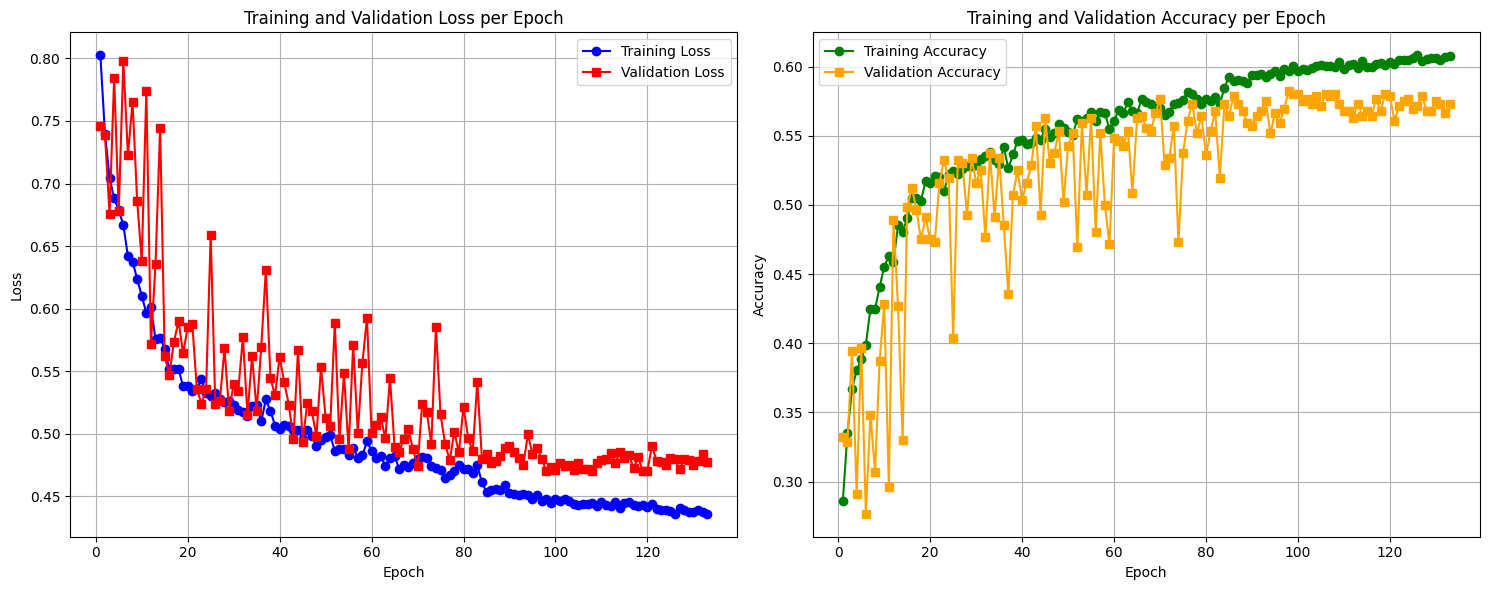

In [19]:
# Plot training progress
plot_training_progress(train_losses, train_accuracies, val_losses, val_accuracies, logs_dir)

### 7.5 Testing and predictions

In [20]:
print("\n" + "="*40)
print("TESTING")
print("="*40)

# Load best model and make predictions
model.load_state_dict(torch.load(best_model_path))
print(f"Loaded best model from: {best_model_path}")

predictions = evaluate(test_loader, model, criterion, device, calculate_accuracy=False)

# Save predictions
save_predictions(predictions, args.dataset)

# Cleanup for memory
del train_dataset, val_dataset, test_dataset
del train_loader, val_loader, test_loader
gc.collect()

print("\n" + "="*60)
print("TRAINING COMPLETED SUCCESSFULLY!")
print("="*60)
print(f"Best {metric_name}: {best_val_metric:.4f}")
print(f"Predictions saved for dataset {args.dataset}")
print(f"Logs and plots saved in: {logs_dir}")


TESTING
Loaded best model from: /kaggle/working/best_model.pth


Iterating eval graphs: 100%|██████████| 25/25 [00:00<00:00, 44.76batch/s]


Predictions saved to /kaggle/working/submission/testset_.csv

TRAINING COMPLETED SUCCESSFULLY!
Best F1: 0.5236
Predictions saved for dataset B
Logs and plots saved in: logs/gin_datasetB_mode1
